# Experiment-1: Linear Regression and Stochastic Gradient Descent
## In this experiment, we will: 
- (1) Get more intuitions about Linear Regression, Closed Form Solution and Gradient Descent. 
- (2) Get your hands dirty on [Housing dataset](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html#housing), which is one of the [LIBSVM Dataset](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/).
- (3) Get some experience about hyper-parameter tuning.
### Note that, In this and the following experiments, we will use the mini framework [simple_ml](https://github.com/lizhaoliu-Lec/simple_ml), which means simple machine learning, written by [lizhaoliu-Lec](https://github.com/lizhaoliu-Lec/).

In [1]:
# First, do a little setup
%pip install simple_ml
import simple_ml
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load the (preprocessed) Housing data.
# fix random seed
np.random.seed(1234)

# read the data
def get_housing_data(data_path='./tmp/exp1/housing.scale', test_size=0.33):
    X, y = load_svmlight_file(data_path)
    # convert sparse matrix to numpy array
    X = X.A
    y = np.reshape(y, (-1, 1))
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_housing_data()
print('We have `%d` training examples and `%d` test examples' % (X_train.shape[0], X_test.shape[0]))
print('X_train shape: ', X_train.shape, ', X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape, ', y_test shape: ', y_test.shape)
print('But we set aside 20% of the training examples for validation.\n')
val_split = 0.2
val_size = int(X_train.shape[0] * val_split)
X_val, y_val, X_train, y_train = X_train[:val_size], y_train[:val_size], X_train[val_size:], y_train[val_size:]
print('Finally, we have...')
print('We have `%d` training examples, `%d` validation examples and `%d` test examples' % (X_train.shape[0], X_val.shape[0],X_test.shape[0]))
print('X_train shape: ', X_train.shape, ', X_val shape: ', X_val.shape, ', X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape, ', y_val shape: ', y_val.shape, ', y_test shape: ', y_test.shape)

We have `339` training examples and `167` test examples
X_train shape:  (339, 13) , X_test shape:  (167, 13)
y_train shape:  (339, 1) , y_test shape:  (167, 1)
But we set aside 20% of the training examples for validation.

Finally, we have...
We have `272` training examples, `67` validation examples and `167` test examples
X_train shape:  (272, 13) , X_val shape:  (67, 13) , X_test shape:  (167, 13)
y_train shape:  (272, 1) , y_val shape:  (67, 1) , y_test shape:  (167, 1)


## Normalized the data:
Normalized the data is very important, typically, we want to normalized the data between 0~1, which is perfect for linear model or svm, and even some deep learning model.
Although the housing data is scaled so that every last number of it is between -1~1, but we are still doing it, for a heads up reminder in the first experiments.

Remember! Normalize the data is very important, especially in the deep learning model.

To normalized the data, we need to normalized all, which means normalized X_train, X_val and X_test, y is not under our consideration in this experiment.
But, X_val and X_test, especially X_test must stayed unseen, during training the model and normalization! 

So we Fit a Standarizer, which compute the mean and variance of X_train, and apply them to the X_val and X_test.
Again, the mean and the variance are computed from X_train only!  

In [4]:
from simple_ml.preprocessing import Standardizer

print('Before normalized the data...')
print('*** X_train *** \nmean: \n%s \nvariance: \n%s' % (np.mean(X_train, axis=0), np.var(X_train, axis=0)))
print('*** X_val *** \nmean: \n%s \nvariance: \n%s' % (np.mean(X_val, axis=0), np.var(X_val, axis=0)))
print('*** X_test *** \nmean: \n%s \nvariance: \n%s' % (np.mean(X_test, axis=0), np.var(X_test, axis=0)))
standardizer = Standardizer()
standardizer.fit(X_train)
X_train = standardizer.transform(X_train)
X_val = standardizer.transform(X_val)
X_test = standardizer.transform(X_test)

print('\nAfter normalized the data...')
print('*** X_train *** \nmean: \n%s \nvariance: \n%s' % (np.mean(X_train, axis=0), np.var(X_train, axis=0)))
print('*** X_val *** \nmean: \n%s \nvariance: \n%s' % (np.mean(X_val, axis=0), np.var(X_val, axis=0)))
print('*** X_test *** \nmean: \n%s \nvariance: \n%s' % (np.mean(X_test, axis=0), np.var(X_test, axis=0)))

Before normalized the data...
*** X_train *** 
mean: 
[ 1.13042745e-15 -2.09799498e-16 -2.18371073e-16 -9.46954933e-17
 -2.58167670e-16  2.31636605e-17  5.33886660e-16 -8.35524460e-16
  1.10879443e-15  3.07199119e-16 -2.94698906e-16  4.70212105e-16
 -4.01027251e-16] 
variance: 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
*** X_val *** 
mean: 
[ 0.00267843 -0.01967268  0.12808386  0.21411339  0.11118432  0.01818043
  0.03501602 -0.1303445   0.15601237  0.22352266  0.01129892  0.1526415
 -0.01967541] 
variance: 
[0.59281651 0.89360058 0.90622635 1.70146876 1.11810286 1.05898405
 1.24369814 0.95170055 0.98123051 0.89686953 0.9461787  0.58472299
 1.1838453 ]
*** X_test *** 
mean: 
[ 0.09974523 -0.05003033 -0.02871776 -0.04941566 -0.0512056  -0.17719251
 -0.03367471  0.02017201  0.05381111  0.02793945  0.26281643 -0.0276142
  0.06298424] 
variance: 
[1.6162999  1.06939269 0.89333116 0.82508414 0.93008356 0.84059932
 1.09541419 0.88654523 1.0301394  1.07073249 0.73493794 1.09467382
 1.00157412]

## Linear Regression: directly optimize it with Closed Form Solution.
We first recap the derivation of Closed Form Solution.
Given $$ \textbf{X} \in \mathbb{R}^{m \times n} $$, where m is the number of examples, and n is the number of features;

And learnable parameter $$ \textbf{w} \in \mathbb{R}^{n \times h}$$, $$ \textbf{b} \in \mathbb{R}^{h}$$.

Linear Model is $$ \textbf{y} = \textbf{X} \cdot \textbf{w} + \textbf{b} $$.

We can add a column of ones in $$ \textbf{X} $$, so it become fully Vectorized form, because we concate $$ \textbf{w} $$ and $$ \textbf{b} $$ together. 

So we get $$ \textbf{X} \in \mathbb{R}^{m \times (n + 1)}$$ and learnable parameter $$ \textbf{W} \in \mathbb{R}^{(n + 1) \times h}$$

Then we make the derivation of Closed Form Solution.
For Linear Regression problem, we want to minimize the loss function $$ J(\hat{y}, y) = \frac{1}{2m}\Sigma_{i=1}^{m}(\hat{y}_{i} - y_{i})  $$

where $$ \hat{y} =  \textbf{X} \cdot \textbf{W} \in \mathbb{R}^{m \times h}$$ is prediction output by the Linear Model.

We can write it as Vectorized form as \begin{eqnarray} J(\hat{y}, y) &=& \frac{1}{2m}(\hat{y} - y)^{T} \cdot (\hat{y} - y) \\
&=& \frac{1}{2m}(\textbf{X} \textbf{W} - y)^{T} \cdot (\textbf{X} \textbf{W} - y) \\
\textbf{W}^{*} &=& \mathop{\arg\min}_{W} J(\hat{y}, y) \end{eqnarray} 

Set $$ \frac{\partial{J}}{\partial{W}} = 0 $$, we get $$ \textbf{W}^{*} = (\textbf{X}^{T}\textbf{X})^{-1}\textbf{X}^{T}\textbf{y} $$
Note that $$ (\textbf{X}^{T}\textbf{X}) $$ maybe uninvertible, so in practice, we use pesudo inverse or Ridge Regression.

Now, it's time to get your hands dirty!

In [5]:
# we first build the linear regression model.
from simple_ml.utils.metric import mean_absolute_error
from simple_ml.linear.model import LinearRegression

# build the linear model
print(10 * '*' + ' LinearRegression model begin ' + 10 * '*')
linear_regression = LinearRegression()
# get closed form solution
linear_regression.fit(X_train, y_train)
test_y_hat = linear_regression.predict(X_test)
train_y_hat = linear_regression.predict(X_train)
training_error = mean_absolute_error(y_train, train_y_hat) / y_train.shape[0]
test_error = mean_absolute_error(y_test, test_y_hat) / y_test.shape[0]
print('Training error: ', training_error)
print('Test error: ', test_error)
print(10 * '*' + ' LinearRegression model end ' + 10 * '*')
print()

********** LinearRegression model begin **********
Training error:  3.215535625153075
Test error:  3.0851717377669634
********** LinearRegression model end **********



## Ridge Regression
Ridge Regression model can be seen as a regularized Linear Model.

And it doesn't have any un invertible problem when getting closed form solution.

The closed form solution of ridge regression is computed as following.
$$ \textbf{W}^{*} = (\textbf{X}^{T}\textbf{X} + \lambda \mathbb{I})^{-1}\textbf{X}^{T}\textbf{y} $$

In [7]:
from simple_ml.linear import RidgeRegression
# build the ridge regression model
print(10 * '*' + ' Ridge LinearRegression model begin ' + 10 * '*')
# the lambda is represented as alpha in the API, by default, alpha=1
ridge_regression = RidgeRegression(alpha=1)
# get closed form solution
ridge_regression.fit(X_train, y_train)
test_y_hat = ridge_regression.predict(X_test)
train_y_hat = ridge_regression.predict(X_train)
training_error = mean_absolute_error(y_train, train_y_hat) / y_train.shape[0]
test_error = mean_absolute_error(y_test, test_y_hat) / y_test.shape[0]
print('Training error: ', training_error)
print('Test error: ', test_error)
print(10 * '*' + ' Ridge LinearRegression model end ' + 10 * '*')
print()

********** Ridge LinearRegression model begin **********
Training error:  3.2018765835462566
Test error:  3.073379101415863
********** Ridge LinearRegression model end **********



## Different lambdas in Ridge Regression
Now we explore the different alpha's impact in Ridge Regression.

We explore it in some magtitude, from $ 10^{-5} $$ to $$ 10^{3} $.

100%|██████████| 11/11 [00:00<00:00, 1378.55it/s]


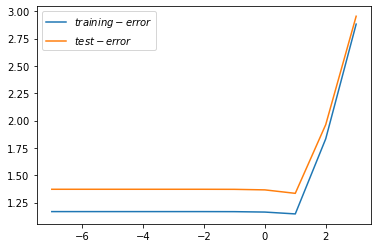

In [17]:
from tqdm import tqdm

magtitude_range = [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
lambdas = [1e-7,1e-6,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
training_errors = []
validation_errors = []
for l in tqdm(lambdas):
    ridge_regression = RidgeRegression(alpha=l)
    # get closed form solution
    ridge_regression.fit(X_train, y_train)
    val_y_hat = ridge_regression.predict(X_val)
    train_y_hat = ridge_regression.predict(X_train)
    training_error = mean_absolute_error(y_train, train_y_hat) / y_train.shape[0]
    val_error = mean_absolute_error(y_val, val_y_hat) / y_val.shape[0]
    training_errors.append(training_error)
    validation_errors.append(val_error)

    
plt.plot(magtitude_range, np.log(np.array(training_errors)), label='$training-error$')
plt.plot(magtitude_range, np.log(np.array(validation_errors)), label='$test-error$')
plt.legend()
plt.show()

# Max-Pooling: Naive backward
Implement the backward pass for the max-pooling operation in the function `max_pool_backward_naive` in the file `cs231n/layers.py`. You don't need to worry about computational efficiency.

Check your implementation with numeric gradient checking by running the following:

In [6]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be on the order of e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

NameError: name 'eval_numerical_gradient_array' is not defined

# Fast layers
Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers in the file `cs231n/fast_layers.py`.

The fast convolution implementation depends on a Cython extension; to compile it you need to run the following from the `cs231n` directory:

```bash
python setup.py build_ext --inplace
```

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

**NOTE:** The fast implementation for pooling will only perform optimally if the pooling regions are non-overlapping and tile the input. If these conditions are not met then the fast pooling implementation will not be much faster than the naive implementation.

You can compare the performance of the naive and fast versions of these layers by running the following:

In [ ]:
# Rel errors should be around e-9 or less
from cs231n.fast_layers import conv_forward_fast, conv_backward_fast
from time import time
np.random.seed(231)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

In [ ]:
# Relative errors should be close to 0.0
from cs231n.fast_layers import max_pool_forward_fast, max_pool_backward_fast
np.random.seed(231)
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))

# Convolutional "sandwich" layers
Previously we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns. In the file `cs231n/layer_utils.py` you will find sandwich layers that implement a few commonly used patterns for convolutional networks.

In [ ]:
from cs231n.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward
np.random.seed(231)
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

In [ ]:
from cs231n.layer_utils import conv_relu_forward, conv_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

# Three-layer ConvNet
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `cs231n/classifiers/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Remember you can use the fast/sandwich layers (already imported for you) in your implementation. Run the following cells to help you debug:

## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [ ]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer. Note: correct implementations may still have relative errors up to the order of e-2.

In [ ]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [ ]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [ ]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

In [ ]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Spatial Batch Normalization
We already saw that batch normalization is a very useful technique for training deep fully-connected networks. As proposed in the original paper [3], batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect the statistics of each feature channel to be relatively consistent both between different images and different locations within the same image. Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over both the minibatch dimension `N` and the spatial dimensions `H` and `W`.


[3] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

## Spatial batch normalization: forward

In the file `cs231n/layers.py`, implement the forward pass for spatial batch normalization in the function `spatial_batchnorm_forward`. Check your implementation by running the following:

In [ ]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(axis=(0, 2, 3)))
print('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

In [ ]:
np.random.seed(231)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

## Spatial batch normalization: backward
In the file `cs231n/layers.py`, implement the backward pass for spatial batch normalization in the function `spatial_batchnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [ ]:
np.random.seed(231)
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

#You should expect errors of magnitudes between 1e-12~1e-06
_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

# Group Normalization
In the previous notebook, we mentioned that Layer Normalization is an alternative normalization technique that mitigates the batch size limitations of Batch Normalization. However, as the authors of [4] observed, Layer Normalization does not perform as well as Batch Normalization when used with Convolutional Layers:

>With fully connected layers, all the hidden units in a layer tend to make similar contributions to the final prediction, and re-centering and rescaling the summed inputs to a layer works well. However, the assumption of similar contributions is no longer true for convolutional neural networks. The large number of the hidden units whose
receptive fields lie near the boundary of the image are rarely turned on and thus have very different
statistics from the rest of the hidden units within the same layer.

The authors of [5] propose an intermediary technique. In contrast to Layer Normalization, where you normalize over the entire feature per-datapoint, they suggest a consistent splitting of each per-datapoint feature into G groups, and a per-group per-datapoint normalization instead. 

![Comparison of normalization techniques discussed so far](normalization.png)
<center>**Visual comparison of the normalization techniques discussed so far (image edited from [5])**</center>

Even though an assumption of equal contribution is still being made within each group, the authors hypothesize that this is not as problematic, as innate grouping arises within features for visual recognition. One example they use to illustrate this is that many high-performance handcrafted features in traditional Computer Vision have terms that are explicitly grouped together. Take for example Histogram of Oriented Gradients [6]-- after computing histograms per spatially local block, each per-block histogram is normalized before being concatenated together to form the final feature vector.

You will now implement Group Normalization. Note that this normalization technique that you are to implement in the following cells was introduced and published to arXiv *less than a month ago* -- this truly is still an ongoing and excitingly active field of research!

[4] [Ba, Jimmy Lei, Jamie Ryan Kiros, and Geoffrey E. Hinton. "Layer Normalization." stat 1050 (2016): 21.](https://arxiv.org/pdf/1607.06450.pdf)


[5] [Wu, Yuxin, and Kaiming He. "Group Normalization." arXiv preprint arXiv:1803.08494 (2018).](https://arxiv.org/abs/1803.08494)


[6] [N. Dalal and B. Triggs. Histograms of oriented gradients for
human detection. In Computer Vision and Pattern Recognition
(CVPR), 2005.](https://ieeexplore.ieee.org/abstract/document/1467360/)

## Group normalization: forward

In the file `cs231n/layers.py`, implement the forward pass for group normalization in the function `spatial_groupnorm_forward`. Check your implementation by running the following:

In [ ]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 6, 4, 5
G = 2
x = 4 * np.random.randn(N, C, H, W) + 10
x_g = x.reshape((N*G,-1))
print('Before spatial group normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x_g.mean(axis=1))
print('  Stds: ', x_g.std(axis=1))

# Means should be close to zero and stds close to one
gamma, beta = np.ones((1,C,1,1)), np.zeros((1,C,1,1))
bn_param = {'mode': 'train'}

out, _ = spatial_groupnorm_forward(x, gamma, beta, G, bn_param)
out_g = out.reshape((N*G,-1))
print('After spatial group normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out_g.mean(axis=1))
print('  Stds: ', out_g.std(axis=1))

## Spatial group normalization: backward
In the file `cs231n/layers.py`, implement the backward pass for spatial batch normalization in the function `spatial_groupnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [ ]:
np.random.seed(231)
N, C, H, W = 2, 6, 4, 5
G = 2
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(1,C,1,1)
beta = np.random.randn(1,C,1,1)
dout = np.random.randn(N, C, H, W)

gn_param = {}
fx = lambda x: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]
fg = lambda a: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]
fb = lambda b: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_groupnorm_forward(x, gamma, beta, G, gn_param)
dx, dgamma, dbeta = spatial_groupnorm_backward(dout, cache)
#You should expect errors of magnitudes between 1e-12~1e-07
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))